In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.multioutput import MultiOutputRegressor

In [2]:
df = pd.read_csv("m_sand_concrete_dataset.csv")
df

,Cement,M_sand,Fly_ash,W_B_ratio,Water_reducer,Gravel,Compressive_strength,CPC
0,404.791210,716.707805,25.596509,0.319968,3.913121,1278.338629,228.661746,162.619943
1,337.775688,638.563169,93.604357,0.478330,3.975574,1231.632520,193.437545,154.611738
2,421.719584,548.381534,16.460782,0.343852,4.730135,1209.436235,205.165174,148.979534
3,389.473606,650.313433,4.491062,0.547399,1.266917,1251.394066,189.348505,160.160457
4,268.835470,545.693631,43.509706,0.393100,2.950379,1012.045390,154.693854,132.971430
...,...,...,...,...,...,...,...,...
81,331.277372,742.475442,24.783956,0.580782,4.007409,1252.597963,208.001125,157.217033
82,412.804077,595.141668,23.666236,0.341222,1.192764,1016.670375,201.796756,139.879017
83,283.394584,785.869819,74.601428,0.587664,4.247044,1084.183431,191.573191,148.668242
84,254.542415,587.275351,81.656876,0.540265,0.286160,1100.239012,165.576196,130.780271


In [4]:
df = df.copy()
iso = IsolationForest(contamination=0.1, random_state=42)

X_features = df.drop(columns=["Compressive_strength", "CPC"])
outlier_pred = iso.fit_predict(X_features)

df_clean = df[outlier_pred == 1].reset_index(drop=True)
print("Shape original:", df.shape)
print("Shape after remove outlier:", df_clean.shape)

Shape original: (86, 8)
Shape after remove outlier: (77, 8)


In [16]:
X = df_clean.iloc[:, :6].values   # feature
y = df_clean.iloc[:, 6:].values   # label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1)

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
multi_gpr = MultiOutputRegressor(gpr, n_jobs=-1)

In [48]:
multi_gpr.fit(X_train, y_train)
multi_gpr

,estimator,GaussianProce...andom_state=0)
,n_jobs,-1
,kernel,1**2 * RBF(le...noise_level=1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,0
,kernel__k1,1**2 * RBF(length_scale=1)


In [49]:
def calc_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse
    
y_pred_train = multi_gpr.predict(X_train)
y_pred_test = multi_gpr.predict(X_test)

# CS
r2_cs_train, rmse_cs_train = calc_metrics(y_train[:,0], y_pred_train[:,0])
r2_cs_test,  rmse_cs_test  = calc_metrics(y_test[:,0],  y_pred_test[:,0])

# CPC
r2_cpc_train, rmse_cpc_train = calc_metrics(y_train[:,1], y_pred_train[:,1])
r2_cpc_test,  rmse_cpc_test  = calc_metrics(y_test[:,1],  y_pred_test[:,1])

print("Train:")
print(f"CS  - R²: {r2_cs_train:.3f}, RMSE: {rmse_cs_train:.3f}")
print(f"CPC - R²: {r2_cpc_train:.3f}, RMSE: {rmse_cpc_train:.3f}")

print("Test:")
print(f"CS  - R²: {r2_cs_test:.3f}, RMSE: {rmse_cs_test:.3f}")
print(f"CPC - R²: {r2_cpc_test:.3f}, RMSE: {rmse_cpc_test:.3f}")

Train:
CS  - R²: 0.886, RMSE: 5.161
CPC - R²: 0.885, RMSE: 2.851
Test:
CS  - R²: 0.904, RMSE: 6.863
CPC - R²: 0.842, RMSE: 3.465


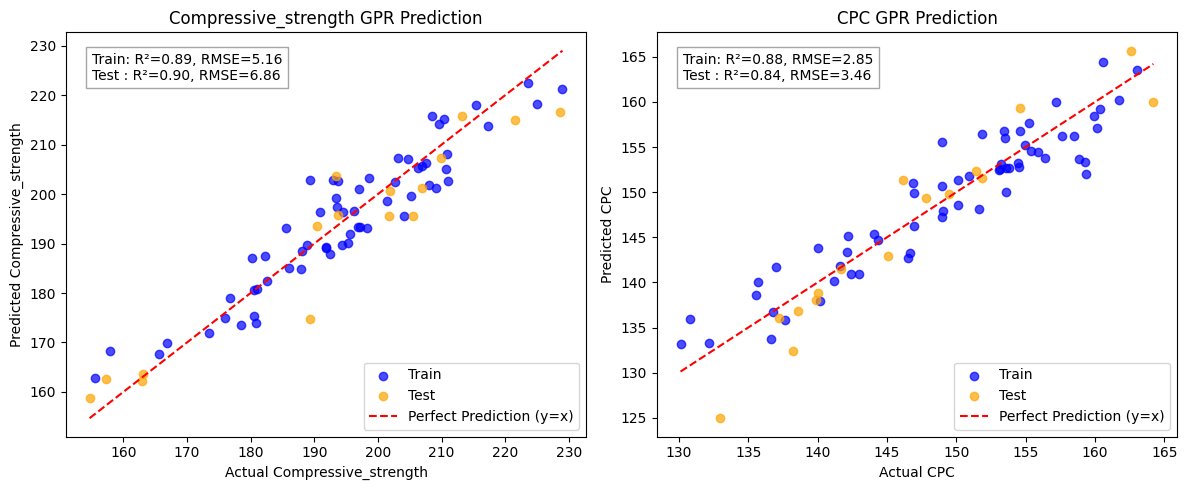

In [50]:
plt.figure(figsize=(12,5))

# Compressive Strength
plt.subplot(1,2,1)
plt.scatter(y_train[:,0], y_pred_train[:,0], alpha=0.7, color="blue", label="Train")
plt.scatter(y_test[:,0], y_pred_test[:,0], alpha=0.7, color="orange", label="Test")
plt.plot([min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())],
         [min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())],
         'r--', label="Perfect Prediction (y=x)")
plt.text(0.05, 0.95,
         f"Train: R²={r2_cs_train:.2f}, RMSE={rmse_cs_train:.2f}\n"
         f"Test : R²={r2_cs_test:.2f}, RMSE={rmse_cs_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual Compressive_strength")
plt.ylabel("Predicted Compressive_strength")
plt.title("Compressive_strength GPR Prediction")
plt.legend()

# CPC
plt.subplot(1,2,2)
plt.scatter(y_train[:,1], y_pred_train[:,1], alpha=0.7, color="blue", label="Train")
plt.scatter(y_test[:,1], y_pred_test[:,1], alpha=0.7, color="orange", label="Test")
plt.plot([min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())],
         [min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())],
         'r--', label="Perfect Prediction (y=x)")
plt.text(0.05, 0.95,
         f"Train: R²={r2_cpc_train:.2f}, RMSE={rmse_cpc_train:.2f}\n"
         f"Test : R²={r2_cpc_test:.2f}, RMSE={rmse_cpc_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual CPC")
plt.ylabel("Predicted CPC")
plt.title("CPC GPR Prediction")
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
import pickle
with open("best_GPR_model.pkl", "wb") as f:
    pickle.dump(multi_gpr, f)

# with open("best_xgb_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)